In [50]:
#Imports

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (accuracy_score,roc_auc_score,confusion_matrix,classification_report,roc_curve, precision_score, recall_score,f1_score)

import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("display.float_format", lambda x: f"{x:0.3f}")

In [3]:
# Load data & define target

random_seed = 172193
np.random.seed(random_seed)

df = pd.read_excel("Employee_Data_Project.xlsx")

print("Raw shape:", df.shape)
display(df.head())

# Target: Attrition (Yes/No -> 1/0)
df['Attrition_lab'] = df['Attrition'].map({'Yes':1 , 'No' :0})

print("Attrition rate:", df['Attrition_lab'].mean())

Raw shape: (4410, 18)


,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeID,Gender,JobLevel,MaritalStatus,Income,NumCompaniesWorked,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction
0,51,No,Travel_Rarely,6,2,1,Female,1,Married,131160,1.000,8,1.000,6,1,0,3.000,4.000
1,31,Yes,Travel_Frequently,10,1,2,Female,1,Single,41890,0.000,8,6.000,3,5,4,3.000,2.000
2,32,No,Travel_Frequently,17,4,3,Male,4,Married,193280,1.000,8,5.000,2,5,3,2.000,2.000
3,38,No,Non-Travel,2,5,4,Male,3,Married,83210,3.000,8,13.000,5,8,5,4.000,4.000
4,32,No,Travel_Rarely,10,1,5,Male,1,Single,23420,4.000,8,9.000,2,6,4,4.000,1.000


Attrition rate: 0.16122448979591836


In [4]:
# Define target & predictor groups

target = "Attrition_lab"

num_vars = [
    "Age", 
    "DistanceFromHome", 
    "Income", 
    "NumCompaniesWorked",
    "TotalWorkingYears", 
    "TrainingTimesLastYear",
    "YearsAtCompany",
    "YearsWithCurrManager"]

ordinal_vars = [
    "Education", 
    "JobLevel", 
    "EnvironmentSatisfaction", 
    "JobSatisfaction"]

nom_vars = [
    "Gender", 
    "BusinessTravel", 
    "MaritalStatus"]

all_vars = num_vars + ordinal_vars + nom_vars


In [5]:
# Train/Test split using same seed and stratification

X = df[all_vars].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=random_seed
)


In [6]:
# Preprocessing pipelines
numeric_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())])

ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))])

nominal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_vars),
    ("ord", ordinal_pipeline, ordinal_vars),
    ("nom", nominal_pipeline, nom_vars)])

# Fit on train, transform both
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed  = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()


In [7]:
# Downsample training data to balance classes

y_train_arr = y_train.values
pos_idx = np.where(y_train_arr == 1)[0]
neg_idx = np.where(y_train_arr == 0)[0]

np.random.seed(random_seed)
keep_neg = np.random.choice(neg_idx, size=len(pos_idx), replace=False)
keep_idx = np.concatenate([pos_idx, keep_neg])

X_train_bal = X_train_processed[keep_idx]
y_train_bal = y_train_arr[keep_idx]

X_train_bal_df = pd.DataFrame(X_train_bal, columns=feature_names)
X_test_df      = pd.DataFrame(X_test_processed, columns=feature_names)


In [33]:
# LASSO logistic model (L1 penalty)
logit_l1 = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l1",
    solver="liblinear",
    scoring="roc_auc",
    max_iter=1000,
    n_jobs=-1,
    refit=True)

# Fit using balanced training set
logit_l1.fit(X_train_bal_df, y_train_bal)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=-1, penalty='l1',
                     scoring='roc_auc', solver='liblinear')

In [41]:
# # Final metrics summary for LASSO model

y_proba_l1 = logit_l1.predict_proba(X_test_df)[:, 1]
y_pred_l1  = (y_proba_l1 >= 0.50).astype(int)

# Metrics
auc_l1 = roc_auc_score(y_test, y_proba_l1)
acc_l1 = accuracy_score(y_test, y_pred_l1)
cm = confusion_matrix(y_test, y_pred_l1)
cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Stayed)","Actual 1(Leaver)"],
    columns=["Pred 0 (Stayed)", "Pred 1(Leaver)"])

print("--- Test Performance ---")
print(f"LASSO: AUC = {auc_l1:0.3f}  ACC = {acc_l1:0.3f}")
print("Confusion Matrix:(rows=Actual,cols = Predicted)\n")
display(cm_df)


--- Test Performance ---
LASSO: AUC = 0.727  ACC = 0.686
Confusion Matrix:(rows=Actual,cols = Predicted)



,Pred 0 (Stayed),Pred 1(Leaver)
Actual 0 (Stayed),767,343
Actual 1(Leaver),73,140


In [60]:
# Coefficient table

coefs = logit_l1.coef_[0]

coef_table = (
    pd.DataFrame({
        "feature": feature_names,   
        "coef": coefs})
        .query("coef != 0")
        .sort_values("coef", key=np.abs, ascending=False))

coef_table

,feature,coef
13,nom__BusinessTravel_Travel_Frequently,1.236
14,nom__BusinessTravel_Travel_Rarely,0.834
16,nom__MaritalStatus_Single,0.760
7,num__YearsWithCurrManager,-0.531
4,num__TotalWorkingYears,-0.379
6,num__YearsAtCompany,0.306
11,ord__JobSatisfaction,-0.263
10,ord__EnvironmentSatisfaction,-0.239
0,num__Age,-0.171
5,num__TrainingTimesLastYear,-0.123


In [22]:
# classifiation report
print(classification_report(
    y_test,
    y_pred_l1,
    target_names=["Stayer (0)", "Leaver (1)"]
))

              precision    recall  f1-score   support

  Stayer (0)       0.91      0.69      0.79      1110
  Leaver (1)       0.29      0.66      0.40       213

    accuracy                           0.69      1323
   macro avg       0.60      0.67      0.59      1323
weighted avg       0.81      0.69      0.72      1323



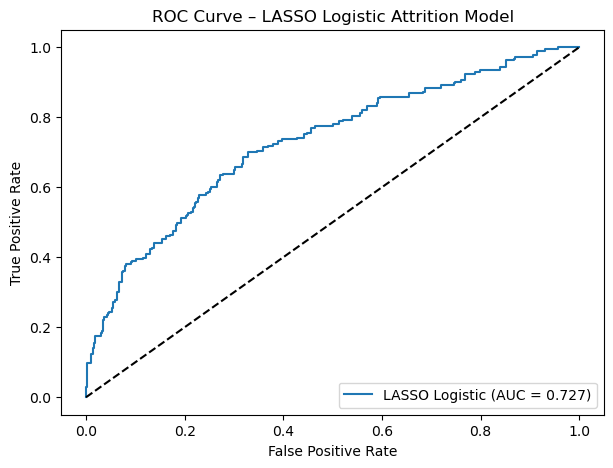

In [49]:
## Lasso Logistic Regression Model

fpr, tpr, _ = roc_curve(y_test, y_proba_l1)
auc_l1 = roc_auc_score(y_test, y_proba_l1)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"LASSO Logistic (AUC = {auc_l1:.3f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – LASSO Logistic Attrition Model")
plt.legend(loc="lower right")
plt.show()


In [43]:
# Create risk ranges

results = pd.DataFrame({
    "Attrition_actual": y_test.values,   
    "Attrition_prob":  y_proba_l1        
})

def classify_risk(p):
    if p < 0.20:
        return "Low"
    elif p < 0.40:
        return "Medium"
    else:
        return "High"

results["risk_group"] = results["Attrition_prob"].apply(classify_risk)


In [52]:
band_summary = (
    results
    .groupby("risk_group")
    .agg(
        n_employees=("Attrition_actual", "size"),
        avg_predicted_risk=("Attrition_prob", "mean"),
        attrition_rate=("Attrition_actual", "mean")
    )
    .reset_index()
)
band_summary = band_summary.sort_values(by="avg_predicted_risk",ascending=True)
band_summary

,risk_group,n_employees,avg_predicted_risk,attrition_rate
1,Low,158,0.143,0.051
2,Medium,458,0.302,0.087
0,High,707,0.576,0.233


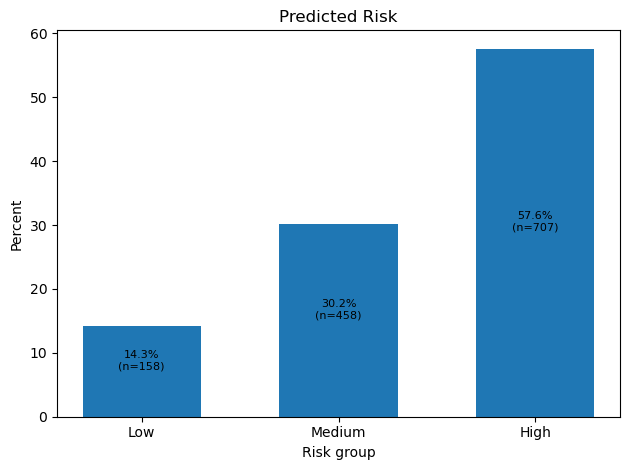

In [61]:
# Plot graph for risk ranges:

plot_df = band_summary.copy()
plot_df["avg_predicted_risk_pct"] = plot_df["avg_predicted_risk"] * 100

x = np.arange(len(plot_df))
width = 0.6  

fig, ax = plt.subplots()

# Avg predicted risk (%)
bars = ax.bar(x, plot_df["avg_predicted_risk_pct"], width, label="Avg predicted risk (%)")

ax.set_xticks(x)
ax.set_xticklabels(plot_df["risk_group"])
ax.set_ylabel("Percent")
ax.set_xlabel("Risk group")
ax.set_title("Predicted Risk")

# labels
for bar,(_,row) in zip(bars,plot_df.iterrows()):
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2, h/2,
        f"{h:.1f}%\n(n={int(row['n_employees'])})",
        ha="center",va="bottom",fontsize=8)

plt.tight_layout()
plt.show()
